In [1]:
import os
os.chdir('/home/yunwei/SNAIL/transmon/monte_carlo/new/full_simulation')
print("Working directory:", os.getcwd())

Working directory: /home/yunwei/SNAIL/transmon/monte_carlo/new/full_simulation


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import colorednoise as cn
import qutip as qt
from noise_generator import GenerateNoise
from hamiltonian_generator import Hamiltonian
from system import *
from joblib import Parallel, delayed
from scipy.optimize import curve_fit

In [3]:
class Simulation:
    def __init__(self, A, initial_state, t_max, sample_rate, num_realizations, S0):
        self.A = A
        self.initial_state = initial_state
        
        # System parameters
        self.phi_ex = 0.2
        self.Ej = 30.19 
        self.Ec = 0.1

        # Setup Hamiltonian for optimal frequency calculation
        self.sc = Hamiltonian(self.phi_ex, self.Ej, self.Ec, [5,3])
        self.optimal_omega,rate = self.sc.optimal_omegad(self.A)
        self.optimal_omega = self.optimal_omega*2*np.pi
        self.sc = Hamiltonian(self.phi_ex, self.Ej, self.Ec, [3,2]) 
        self.sample_rate = sample_rate
        self.num_realizations = num_realizations
        self.S0 = S0
        self.t_max = t_max
        self.cplus_state, self.kick_and_sigmax, self.get_projector = self.sc.setup_floquet_system(A,self.optimal_omega)
        self.detuning = np.real(self.sc.H)[2,2] - self.optimal_omega

    def noise_check(self, if_plot=False):
        # Initialize arrays to store results
        tnoise_max = int(self.t_max)             # number of samples
        relative_PSD_strength = self.S0**2
        ifwhite = False               # True for white noise, False for 1/f noise
        
        gn = GenerateNoise(self.sample_rate, tnoise_max, relative_PSD_strength, self.num_realizations, ifwhite)
        trajs = gn.generate_colored_noise()
        self.trajs = trajs
        if if_plot:
            gn.analyze_noise_psd(trajs)
    
    def operators(self):
        sds = self.sc.noise
        sop = self.sc.s
        H_control = self.sc.H_control
        H0 = self.sc.H
        diagonal_energies = np.diag(self.sc.H) - self.sc.H[0,0]
        H0 = np.diag(diagonal_energies)
        sds = qt.Qobj(sds)
        sop = qt.Qobj(sop)
        H_control = qt.Qobj(H_control)
        H0 = qt.Qobj(H0)
        return sds, sop, H_control, H0,

    def I_control(self, ramp_time, T, amplitude=1.0):
        if ramp_time <= 0 or T < 2 * ramp_time:
            raise ValueError("Invalid parameters: Ensure ramp_time > 0 and T >= 2 * ramp_time")

        def pulse(t):
            t = np.asarray(t)
            result = np.zeros_like(t, dtype=float)

            # Sin-squared ramp up
            mask1 = (t > 0) & (t < ramp_time)
            result[mask1] = amplitude * np.sin((np.pi / 2) * (t[mask1] / ramp_time))**2

            # Flat top
            mask2 = (t >= ramp_time) & (t <= T - ramp_time)
            result[mask2] = amplitude

            # Sin-squared ramp down
            mask3 = (t > T - ramp_time) & (t < T)
            result[mask3] = amplitude * np.sin((np.pi / 2) * (1 - (t[mask3] - (T - ramp_time)) / ramp_time))**2

            if result.shape == ():
                return float(result)
            return result

        return pulse

    def Q_control(self, freq, ramp_time, T, amplitude=1.0):
        if ramp_time <= 0 or T < 2 * ramp_time:
            raise ValueError("Invalid parameters: Ensure ramp_time > 0 and T >= 2 * ramp_time")

        peak = amplitude * np.pi / (2 * ramp_time)

        def pulse_derivative(t):
            t = np.asarray(t)
            result = np.zeros_like(t, dtype=float)

            # Derivative of ramp up
            mask1 = (t > 0) & (t < ramp_time)
            result[mask1] = peak * np.sin(np.pi * t[mask1] / ramp_time)

            # Derivative of ramp down
            mask3 = (t > T - ramp_time) & (t < T)
            result[mask3] = -peak * np.sin(np.pi * (t[mask3] - (T - ramp_time)) / ramp_time)

            result = -result / freq

            if result.shape == ():
                return float(result)
            return result

        return pulse_derivative

    import numpy as np

    def A_function(self, freq, ramp_time, T, amplitude=1.0):
        if ramp_time <= 0 or T < 2 * ramp_time:
            raise ValueError("Invalid parameters: Ensure ramp_time > 0 and T >= 2 * ramp_time")

        deriv_peak = amplitude * np.pi / (2 * ramp_time)
        pi_over_2 = np.pi / 2
        pi_over_rt = np.pi / ramp_time
        inv_freq = 1.0 / freq

        def A(t):
            t = np.asarray(t, dtype=float)
            result = np.full_like(t, fill_value=0.0, dtype=float)

            # Use boolean masks once
            mask1 = (t > 0) & (t < ramp_time)
            mask2 = (t >= ramp_time) & (t <= T - ramp_time)
            mask3 = (t > T - ramp_time) & (t < T)

            # Ramp up calculations
            if np.any(mask1):
                ang1 = pi_over_2 * (t[mask1] / ramp_time)
                sin_ang1 = np.sin(ang1)
                I1 = amplitude * sin_ang1 * sin_ang1
                Q1 = -deriv_peak * np.sin(pi_over_rt * t[mask1]) * inv_freq
                result[mask1] = np.hypot(I1, Q1)  # More efficient for sqrt(I^2+Q^2)

            # Flat top amplitude is constant
            if np.any(mask2):
                result[mask2] = amplitude

            # Ramp down calculations
            if np.any(mask3):
                ang3 = pi_over_2 * (1 - (t[mask3] - (T - ramp_time)) / ramp_time)
                sin_ang3 = np.sin(ang3)
                I3 = amplitude * sin_ang3 * sin_ang3
                Q3 = deriv_peak * np.sin(pi_over_rt * (t[mask3] - (T - ramp_time))) * inv_freq
                result[mask3] = np.hypot(I3, Q3)

            if result.shape == ():
                return float(result)
            return result

        return A


    def phi_function(self, freq, ramp_time, T, amplitude=1.0):
        if ramp_time <= 0 or T < 2 * ramp_time:
            raise ValueError("Invalid parameters: Ensure ramp_time > 0 and T >= 2 * ramp_time")

        deriv_peak = amplitude * np.pi / (2 * ramp_time)
        pi_over_2 = np.pi / 2
        pi_over_rt = np.pi / ramp_time
        inv_freq = 1.0 / freq

        def phi(t):
            t = np.asarray(t, dtype=float)
            result = np.zeros_like(t, dtype=float)

            mask1 = (t > 0) & (t < ramp_time)
            mask2 = (t >= ramp_time) & (t <= T - ramp_time)
            mask3 = (t > T - ramp_time) & (t < T)

            # Ramp up phase
            if np.any(mask1):
                ang1 = pi_over_2 * (t[mask1] / ramp_time)
                sin_ang1 = np.sin(ang1)
                I1 = amplitude * sin_ang1 * sin_ang1
                Q1 = -deriv_peak * np.sin(pi_over_rt * t[mask1]) * inv_freq
                result[mask1] = np.arctan2(Q1, I1)

            # Plateau phase
            if np.any(mask2):
                result[mask2] = 0.0

            # Ramp down phase
            if np.any(mask3):
                ang3 = pi_over_2 * (1 - (t[mask3] - (T - ramp_time)) / ramp_time)
                sin_ang3 = np.sin(ang3)
                I3 = amplitude * sin_ang3 * sin_ang3
                Q3 = deriv_peak * np.sin(pi_over_rt * (t[mask3] - (T - ramp_time))) * inv_freq
                result[mask3] = np.arctan2(Q3, I3)

            if result.shape == ():
                return float(result)
            return result

        return phi

    def A_function_longtime(self, freq, ramp_time, T, total_duration, amplitude=1.0):
        """
        Extended amplitude function: ramp-up (0 to ramp_time) then constant until total_duration.
        
        Parameters:
        - freq: frequency for DRAG correction
        - ramp_time: duration of the ramp-up phase
        - T: original pulse duration (used for ramp shape calculation)
        - total_duration: total duration of the extended pulse
        - amplitude: peak amplitude (default 1.0)
        """
        if ramp_time <= 0 or total_duration < ramp_time:
            raise ValueError("Invalid parameters: Ensure ramp_time > 0 and total_duration >= ramp_time")

        deriv_peak = amplitude * np.pi / (2 * ramp_time)
        pi_over_2 = np.pi / 2
        pi_over_rt = np.pi / ramp_time
        inv_freq = 1.0 / freq

        def A(t):
            t = np.asarray(t, dtype=float)
            result = np.full_like(t, fill_value=0.0, dtype=float)

            # Ramp up phase: 0 < t < ramp_time
            mask1 = (t > 0) & (t < ramp_time)
            # Constant phase: ramp_time <= t <= total_duration
            mask2 = (t >= ramp_time) & (t <= total_duration)

            # Ramp up calculations (same as A_function)
            if np.any(mask1):
                ang1 = pi_over_2 * (t[mask1] / ramp_time)
                sin_ang1 = np.sin(ang1)
                I1 = amplitude * sin_ang1 * sin_ang1
                Q1 = -deriv_peak * np.sin(pi_over_rt * t[mask1]) * inv_freq
                result[mask1] = np.hypot(I1, Q1)

            # Constant amplitude after ramp
            if np.any(mask2):
                result[mask2] = amplitude

            if result.shape == ():
                return float(result)
            return result

        return A

    def phi_function_longtime(self, freq, ramp_time, T, total_duration, amplitude=1.0):
        """
        Extended phase function: ramp-up phase (0 to ramp_time) then zero until total_duration.
        
        Parameters:
        - freq: frequency for DRAG correction
        - ramp_time: duration of the ramp-up phase
        - T: original pulse duration (used for ramp shape calculation)
        - total_duration: total duration of the extended pulse
        - amplitude: peak amplitude (default 1.0)
        """
        if ramp_time <= 0 or total_duration < ramp_time:
            raise ValueError("Invalid parameters: Ensure ramp_time > 0 and total_duration >= ramp_time")

        deriv_peak = amplitude * np.pi / (2 * ramp_time)
        pi_over_2 = np.pi / 2
        pi_over_rt = np.pi / ramp_time
        inv_freq = 1.0 / freq

        def phi(t):
            t = np.asarray(t, dtype=float)
            result = np.zeros_like(t, dtype=float)

            # Ramp up phase: 0 < t < ramp_time
            mask1 = (t > 0) & (t < ramp_time)
            # Constant phase: ramp_time <= t <= total_duration (phi = 0)
            mask2 = (t >= ramp_time) & (t <= total_duration)

            # Ramp up phase calculation (same as phi_function)
            if np.any(mask1):
                ang1 = pi_over_2 * (t[mask1] / ramp_time)
                sin_ang1 = np.sin(ang1)
                I1 = amplitude * sin_ang1 * sin_ang1
                Q1 = -deriv_peak * np.sin(pi_over_rt * t[mask1]) * inv_freq
                result[mask1] = np.arctan2(Q1, I1)

            # Plateau phase: phi = 0
            if np.any(mask2):
                result[mask2] = 0.0

            if result.shape == ():
                return float(result)
            return result

        return phi



In [4]:
t_max = 100000
A = 1e-3 * 2 * np.pi
initial_state = []
ramp_time = 100
num_realizations = 100
S0 = 1e-5
sample_rate = 1        # per ns
sim = Simulation(A,initial_state, t_max,sample_rate, num_realizations,S0)
sim.noise_check()
# Original pulse parameters
freq = 5e9
ramp_time = 20e-9
T = 40e-9  # original pulse duration
amplitude = 1.0

# Extended duration (e.g., for Ramsey experiment)
total_duration = 1e-6  # 1 microsecond

A = sim.A_function_longtime(freq, ramp_time, T, total_duration, amplitude)
phi = sim.phi_function_longtime(freq, ramp_time, T, total_duration, amplitude)

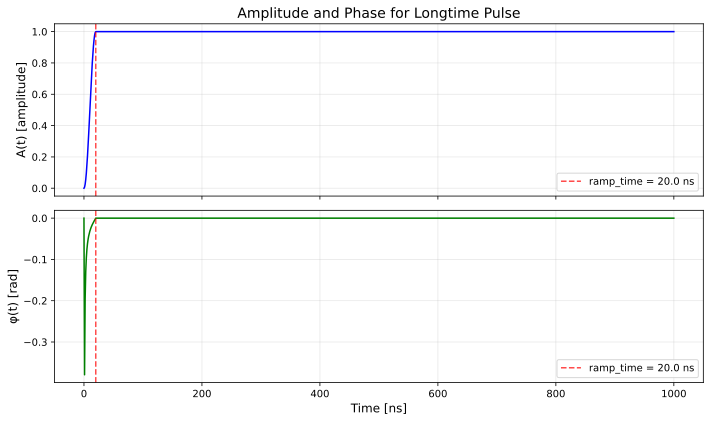

In [5]:
# Plot A and phi functions
import matplotlib.pyplot as plt

# Time array for plotting
t = np.linspace(0, total_duration, 1000)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Plot A(t)
ax1.plot(t * 1e9, A(t), 'b-', linewidth=1.5)
ax1.axvline(x=ramp_time * 1e9, color='r', linestyle='--', alpha=0.7, label=f'ramp_time = {ramp_time*1e9:.1f} ns')
ax1.set_ylabel('A(t) [amplitude]', fontsize=12)
ax1.set_title('Amplitude and Phase for Longtime Pulse', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot phi(t)
ax2.plot(t * 1e9, phi(t), 'g-', linewidth=1.5)
ax2.axvline(x=ramp_time * 1e9, color='r', linestyle='--', alpha=0.7, label=f'ramp_time = {ramp_time*1e9:.1f} ns')
ax2.set_xlabel('Time [ns]', fontsize=12)
ax2.set_ylabel('φ(t) [rad]', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
def _setup_ramsey_sigmax_driven(total_time, A):
    """Common setup for Ramsey sigmax experiments."""
    initial_state = []
    t_max = int(1e8)
    num_realizations = 100
    S0 = 1e-5
    sample_rate = 0.01        # per ns
    sim = Simulation(A, initial_state, t_max, sample_rate, num_realizations, S0)
    sim.noise_check()

    time_points = np.linspace(0, total_time, total_time)
    T = total_time
    ramp_time = 100
    gamma = 1 / (2e4)

    sds, sop, H_control, H0 = sim.operators()
    freq = np.abs(np.real(H0.full())[2,2] - sim.optimal_omega)
    A_func = sim.A_function_longtime(freq, ramp_time, T, t_max, sim.A)
    phi_func = sim.phi_function_longtime(freq, ramp_time, T, t_max, sim.A)

    drive_term = lambda t, args: A_func(t) * np.cos(sim.optimal_omega * t + phi_func(t))

    opts = {'nsteps': sim.t_max, 'atol': 1e-12, 'rtol': 1e-12}
    c_ops = [np.sqrt(gamma) * qt.Qobj(sop)]
    plus_initial_state = 1/np.sqrt(2)*(qt.basis(6, 0)+qt.basis(6, 1))

    return sim, time_points, sds, sop, H_control, H0, drive_term, opts, c_ops, plus_initial_state

def _setup_ramsey_sigmax_undriven(total_time, A):
    """Common setup for Ramsey sigmax experiments."""
    initial_state = []
    t_max = int(1e8)
    num_realizations = 100
    S0 = 1e-5
    sample_rate = 0.01        # per ns
    sim = Simulation(A, initial_state, t_max, sample_rate, num_realizations, S0)
    sim.noise_check()

    time_points = np.linspace(0, total_time, total_time)
    T = total_time
    ramp_time = 100
    gamma = 1 / (2e4)

    sds, sop, H_control, H0 = sim.operators()
    freq = np.abs(np.real(H0.full())[2,2] - sim.optimal_omega)
    A_func = sim.A_function_longtime(freq, ramp_time, T, t_max, sim.A)
    phi_func = sim.phi_function_longtime(freq, ramp_time, T, t_max, sim.A)

    drive_term = lambda t, args: A_func(t) * np.cos(sim.optimal_omega * t + phi_func(t))

    opts = {'nsteps': sim.t_max, 'atol': 1e-12, 'rtol': 1e-12}
    c_ops = [np.sqrt(gamma) * qt.Qobj(sop)]
    plus_initial_state = 1/np.sqrt(2)*(qt.basis(6, 0)+qt.basis(6, 1))

    return sim, time_points, sds, sop, H_control, H0, drive_term, opts, c_ops, plus_initial_state



def compute_ramsey_sigmax_driven(total_time, A):
    """
    Compute Ramsey experiment measuring sigmax for the driven case only.
    Returns: time_points, driven_avg
    """
    sim, time_points, sds, sop, H_control, H0, drive_term, opts, c_ops, plus_initial_state = _setup_ramsey_sigmax_driven(total_time, A)

    from joblib import Parallel, delayed

    def run_driven(traj_idx):
        traj = np.cos(sim.phi_ex*np.pi)*(np.cos(sim.trajs[traj_idx]*np.pi)-1) - np.sin(sim.phi_ex*np.pi)*np.sin(sim.trajs[traj_idx]*np.pi)
        noise_term = lambda t, args: traj[int(t * sim.sample_rate)] if t < sim.t_max else 0
        H = [H0, [sds, noise_term], [H_control, drive_term]]
        result = qt.mesolve(H, plus_initial_state, time_points, c_ops, options=opts)
        vals = np.zeros(len(time_points))
        for j, state_t in enumerate(result.states):
            floquet_states, sigmax, sigmas_op = sim.kick_and_sigmax(time_points[j])
            vals[j] = np.real(qt.expect(qt.Qobj(sigmax), state_t))
        return vals

    print("Running driven case (sigmax)...")
    driven_results = Parallel(n_jobs=-1)(delayed(run_driven)(i) for i in range(sim.num_realizations))
    driven_avg = np.mean(np.array(driven_results), axis=0)

    return time_points, driven_avg


def compute_ramsey_sigmax_undriven(total_time, A):
    """
    Compute Ramsey experiment measuring sigmax for the undriven case only.
    Returns: time_points, undriven_avg
    """
    sim, time_points, sds, sop, H_control, H0, drive_term, opts, c_ops, plus_initial_state = _setup_ramsey_sigmax_undriven(total_time, A)

    from joblib import Parallel, delayed

    def run_undriven(traj_idx):
        traj = np.cos(sim.phi_ex*np.pi)*(np.cos(sim.trajs[traj_idx]*np.pi)-1) - np.sin(sim.phi_ex*np.pi)*np.sin(sim.trajs[traj_idx]*np.pi)
        noise_term = lambda t, args: traj[int(t * sim.sample_rate)] if t < sim.t_max else 0
        H = [H0, [sds, noise_term]]
        result = qt.mesolve(H, plus_initial_state, time_points, c_ops, options=opts)
        vals = np.zeros(len(time_points))
        for j, state_t in enumerate(result.states):
            floquet_states, sigmax, sigmas_op = sim.kick_and_sigmax(time_points[j])
            vals[j] = np.real(qt.expect(qt.Qobj(sigmax), state_t))
        return vals

    print("Running undriven case (sigmax)...")
    undriven_results = Parallel(n_jobs=-1)(delayed(run_undriven)(i) for i in range(sim.num_realizations))
    undriven_avg = np.mean(np.array(undriven_results), axis=0)

    return time_points, undriven_avg



In [ ]:
import pickle

# Run undriven Ramsey sigmax and update existing data
A_val = 5e-3 * 2 * np.pi
total_time = 110000

time_pts, undriven = compute_ramsey_sigmax_undriven(total_time, A_val)

# Load existing data and add undriven results
with open('ramsey_sigmax_data.pkl', 'rb') as f:
    data = pickle.load(f)

data['undriven'] = undriven

with open('ramsey_sigmax_data.pkl', 'wb') as f:
    pickle.dump(data, f)

print(f"Undriven data updated in ramsey_sigmax_data.pkl")

Running undriven case (sigmax)...


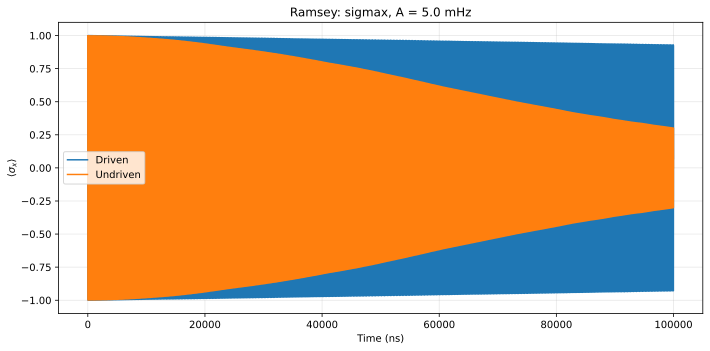

In [13]:
import pickle

# Load data from pickle file
with open('ramsey_sigmax_data.pkl', 'rb') as f:
    data = pickle.load(f)

time_pts = data['time_pts']
driven = data['driven']
undriven = data['undriven']
A_val = data['A_val']

# Only plot up to 100000 ns
mask = time_pts <= 100000

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(time_pts[mask], driven[mask], label='Driven', linewidth=1.5)
ax.plot(time_pts[mask], undriven[mask], label='Undriven', linewidth=1.5)
ax.set_xlabel('Time (ns)')
ax.set_ylabel(r'$\langle \sigma_x \rangle$')
ax.set_title(f'Ramsey: sigmax, A = {A_val/(2*np.pi)*1e3:.1f} mHz')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Running undriven case (sigmas)...


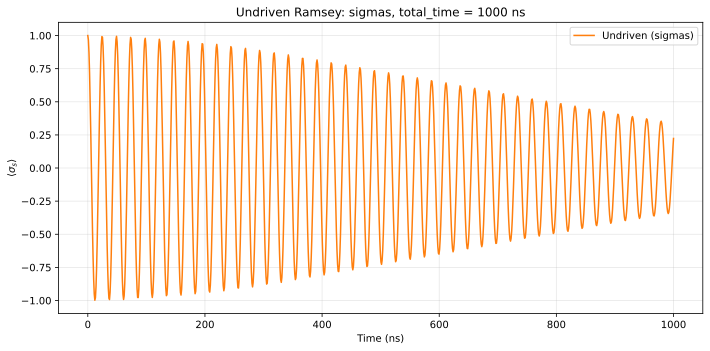

In [9]:

def compute_ramsey_sigmas(total_time, A):
    """
    Compute undriven Ramsey experiment measuring sigmas.
    Returns: time_points, undriven_avg
    """
    initial_state = []
    t_max = 100000
    num_realizations = 100
    S0 = 1e-5
    sample_rate = 1        # per ns
    sim = Simulation(A, initial_state, t_max, sample_rate, num_realizations, S0)
    sim.noise_check()

    time_points = np.linspace(0, total_time, 1000)
    gamma = 1 / (2e4)

    sds, sop, H_control, H0 = sim.operators()

    opts = {'nsteps': sim.t_max, 'atol': 1e-12, 'rtol': 1e-12}
    c_ops = [np.sqrt(gamma) * qt.Qobj(sop)]
    plus_initial_state = 1/np.sqrt(2)*(qt.basis(6, 0)+qt.basis(6, 2))

    from joblib import Parallel, delayed

    def run_undriven(traj_idx):
        traj = np.cos(sim.phi_ex*np.pi)*(np.cos(sim.trajs[traj_idx]*np.pi)-1) - np.sin(sim.phi_ex*np.pi)*np.sin(sim.trajs[traj_idx]*np.pi)
        noise_term = lambda t, args: traj[int(t * sim.sample_rate)] if t < sim.t_max else 0
        H = [H0, [sds, noise_term]]
        result = qt.mesolve(H, plus_initial_state, time_points, c_ops, options=opts)
        vals = np.zeros(len(time_points))
        for j, state_t in enumerate(result.states):
            floquet_states, sigmax, sigmas_op = sim.kick_and_sigmax(time_points[j])
            vals[j] = np.real(qt.expect(qt.Qobj(sigmas_op), state_t))
        return vals

    print("Running undriven case (sigmas)...")
    undriven_results = Parallel(n_jobs=-1)(delayed(run_undriven)(i) for i in range(sim.num_realizations))
    undriven_avg = np.mean(np.array(undriven_results), axis=0)

    return time_points, undriven_avg
# Undriven case with sigmas, total_time = 400 ns
A_val = 0e-3 * 2 * np.pi
total_time_short = 1000

time_pts_s, undriven_s = compute_ramsey_sigmas(total_time_short, A_val)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(time_pts_s, undriven_s, label='Undriven (sigmas)', linewidth=1.5, color='tab:orange')
ax.set_xlabel('Time (ns)')
ax.set_ylabel(r'$\langle \sigma_s \rangle$')
ax.set_title(f'Undriven Ramsey: sigmas, total_time = {total_time_short} ns')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()